En este cuaderno vamos a entrenar un autoencoder usando PyTorch con el dataset FashionMNIST. Además, exploraremos la aplicación de este autoencoder para clustering, reducción de dimensionalidad y detección de anomalías (usando datos mezclados de FashionMNIST y MNIST).

### Cargar Fashion MNIST y echar un vistazo al dataset

- Importamos librerías
- Cargamos FashionMNIST
- Crearemos DataLoaders (entrenamiento y test)
- Mostraremos algunos ejemplos aleatorios
- Mostraremos un histograma de la distribución de clases


Usando dispositivo: cuda


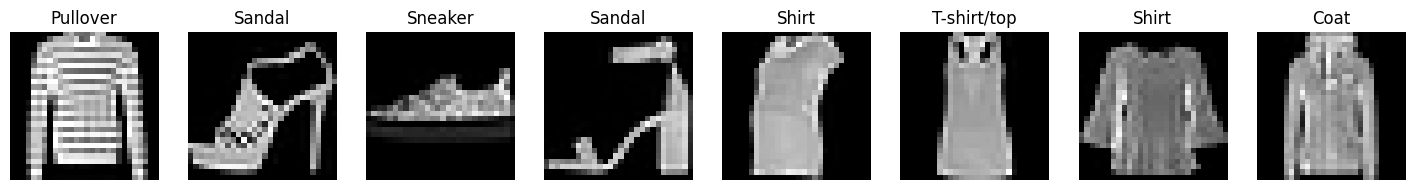

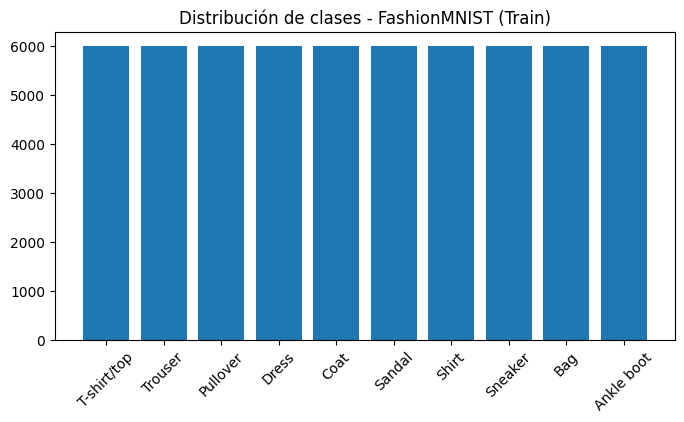

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import random

# Comprobar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Transformaciones para FashionMNIST
transform = transforms.Compose([transforms.ToTensor()])

# Cargar dataset FashionMNIST
fashion_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
fashion_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Clases (etiquetas) de FashionMNIST
fashion_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Crear DataLoader de entrenamiento y de test
batch_size = 128
train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)

# Función para mostrar imágenes
def mostrar_imagenes_en_fila(imgs, labels, classes, num_im=8):
    fig, axes = plt.subplots(1, num_im, figsize=(18, 2))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i].squeeze(), cmap='gray')
        ax.set_title(classes[labels[i]])
        ax.axis("off")
    plt.show()

# Mostrar algunos ejemplos al azar del dataset de entrenamiento
data_iter = iter(train_loader)
images, labels = next(data_iter)
mostrar_imagenes_en_fila(images, labels, fashion_classes, num_im=8)

# Mostrar histograma de la distribución de clases en todo el dataset de entrenamiento
all_labels = [label for _, label in fashion_train]
plt.figure(figsize=(8,4))
plt.hist(all_labels, bins=np.arange(len(fashion_classes)+1)-0.5, rwidth=0.8, align='mid')
plt.xticks(range(len(fashion_classes)), fashion_classes, rotation=45)
plt.title("Distribución de clases - FashionMNIST (Train)")
plt.show()

### Creamos un stacked autoencoder

- Definimos una clase `Autoencoder` que herede de `nn.Module`
- El encoder tendrá varias capas lineales con activaciones ReLU
- El decoder reconstruirá la imagen a partir de la representación latente

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        
        # Tamaño de entrada: 28x28 = 784
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Como las imágenes están normalizadas [0,1]
        )
        
    def forward(self, x):
        # x: [batch_size, 1, 28, 28]
        x = x.view(x.size(0), -1)           # Aplanamos la imagen
        encoded = self.encoder(x)           # Codificamos
        decoded = self.decoder(encoded)     # Decodificamos
        decoded = decoded.view(x.size(0), 1, 28, 28)  # Reconstruimos la forma [N,1,28,28]
        return decoded

# Instanciamos el modelo y lo movemos a device
latent_dim = 64
model = Autoencoder(latent_dim=latent_dim).to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


### Definimos funciones de entrenamiento

- Definimos la función `train_autoencoder` que hace:
  - for epoch in range(epochs):
    - batch loop
    - forward -> loss -> backward -> step
  - almacena historial de pérdidas

In [11]:
def train_autoencoder(model, train_loader, epochs=30, lr=1e-3):
    # Definimos el optimizador y el criterio de pérdida
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Podemos usar MSE o BCE
    
    history = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        
        for images, _ in train_loader:
            images = images.to(device)
            
            # Forward
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
    
    return history

### Definimos funciones de evaluación

**Descripción de la celda:**
- `plot_loss_curve(history)`: grafica la pérdida a lo largo de las épocas.
- `ver_reconstrucciones(model, data_loader, num_images=8)`: muestra un conjunto de imágenes y sus reconstrucciones lado a lado.

In [13]:
def plot_loss_curve(history):
    plt.figure(figsize=(8,5))
    plt.plot(history, 'o-', label='Train Loss')
    plt.title("Curva de pérdida del entrenamiento")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.show()

def ver_reconstrucciones(model, data_loader, num_images=8):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    
    with torch.no_grad():
        reconstructions = model(images)
    
    images = images.cpu()
    reconstructions = reconstructions.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(18, 4))
    for i in range(num_images):
        # Imagen original
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis("off")
        
        # Reconstruida
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].axis("off")
    
    plt.show()

### Entrenamos el modelo

- Llamamos a `train_autoencoder(...)` para entrenar
- Graficamos la pérdida con `plot_loss_curve`
- Observamos reconstrucciones con `ver_reconstrucciones`

Epoch [1/30], Loss: 0.0292
Epoch [2/30], Loss: 0.0207
Epoch [3/30], Loss: 0.0182
Epoch [4/30], Loss: 0.0166
Epoch [5/30], Loss: 0.0155
Epoch [6/30], Loss: 0.0146
Epoch [7/30], Loss: 0.0139
Epoch [8/30], Loss: 0.0132
Epoch [9/30], Loss: 0.0127
Epoch [10/30], Loss: 0.0123
Epoch [11/30], Loss: 0.0119
Epoch [12/30], Loss: 0.0115
Epoch [13/30], Loss: 0.0113
Epoch [14/30], Loss: 0.0110
Epoch [15/30], Loss: 0.0108
Epoch [16/30], Loss: 0.0106
Epoch [17/30], Loss: 0.0104
Epoch [18/30], Loss: 0.0102
Epoch [19/30], Loss: 0.0100
Epoch [20/30], Loss: 0.0098
Epoch [21/30], Loss: 0.0097
Epoch [22/30], Loss: 0.0096
Epoch [23/30], Loss: 0.0094
Epoch [24/30], Loss: 0.0093
Epoch [25/30], Loss: 0.0092
Epoch [26/30], Loss: 0.0091
Epoch [27/30], Loss: 0.0090
Epoch [28/30], Loss: 0.0089
Epoch [29/30], Loss: 0.0088
Epoch [30/30], Loss: 0.0087


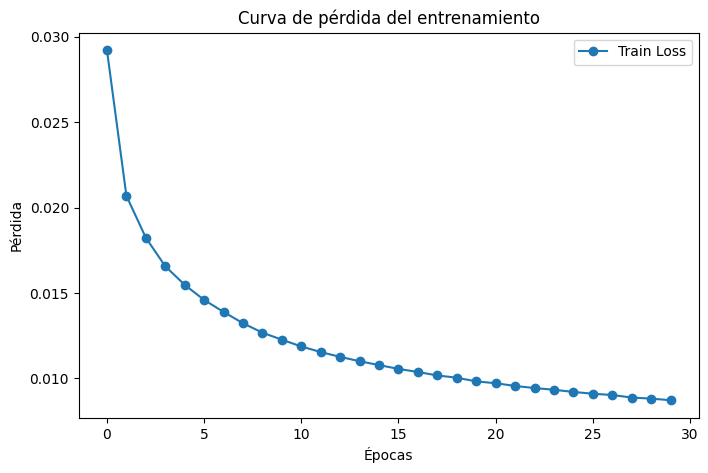

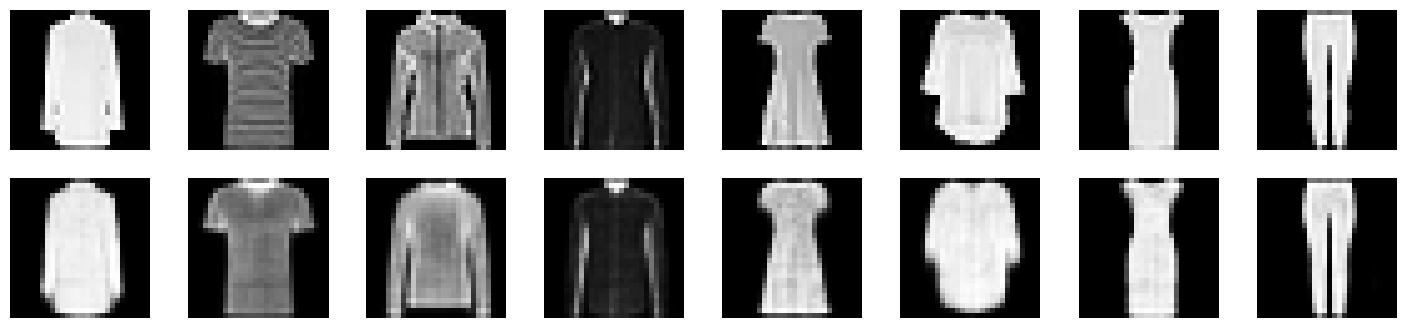

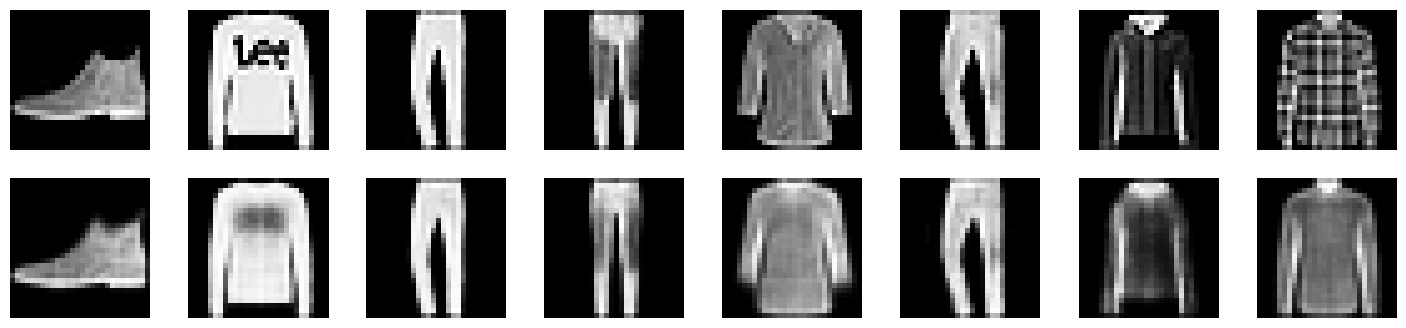

In [15]:
num_epochs = 30
history = train_autoencoder(model, train_loader, epochs=num_epochs, lr=1e-3)

# Graficar la curva de pérdidas
plot_loss_curve(history)

# Ver reconstrucciones en el set de entrenamiento
ver_reconstrucciones(model, train_loader, num_images=8)

# Ver reconstrucciones en el set de test
ver_reconstrucciones(model, test_loader, num_images=8)

### Evaluamos y extraemos embeddings

- Definimos `obtener_latentes(...)` para extraer el vector latente
- Realizamos `KMeans(n_clusters=10)` en esos vectores latentes
- Asignamos a cada clúster la clase mayoritaria
- Mostramos histograma de asignaciones vs etiquetas verdaderas
- Calculamos matriz de confusión y exactitud

Asignación cluster->label mayoritaria: {0: 9, 1: 3, 2: 8, 3: 7, 4: 3, 5: 2, 6: 6, 7: 9, 8: 0, 9: 1}
Exactitud (train): 0.5544166666666667


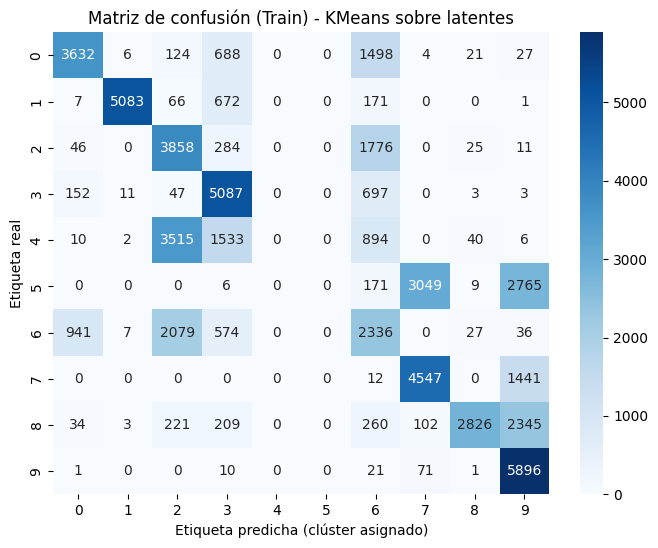

In [16]:
def obtener_latentes(model, data_loader):
    """Extrae la representación latente de todo el dataset dado."""
    latentes = []
    etiquetas = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            
            # Encoder
            x = images.view(images.size(0), -1)
            encoded = model.encoder(x)
            
            latentes.append(encoded.cpu().numpy())
            etiquetas.extend(labels.numpy())
    
    latentes = np.concatenate(latentes, axis=0)
    etiquetas = np.array(etiquetas)
    return latentes, etiquetas

# Extraer latentes de train y test (podríamos usar solo uno)
train_latentes, train_labels = obtener_latentes(model, train_loader)

# Clustering con KMeans en train_latentes
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(train_latentes)

# Asignar a cada clúster la clase mayoritaria
def asignar_etiqueta_cluster(cluster_labels, true_labels):
    # cluster_labels: array con label de cluster por cada ejemplo
    # true_labels: array con etiqueta real por cada ejemplo
    from collections import Counter
    
    cluster_to_label = {}
    for c in range(10):  # tenemos 10 clústers
        indices_cluster = np.where(cluster_labels == c)[0]
        labels_cluster = true_labels[indices_cluster]
        # Clase mayoritaria en este clúster
        if len(labels_cluster) > 0:
            mas_comun = Counter(labels_cluster).most_common(1)[0][0]
            cluster_to_label[c] = mas_comun
        else:
            cluster_to_label[c] = -1  # sin asignar
    
    # Crear predicciones
    pred_labels = np.array([cluster_to_label[c] for c in cluster_labels])
    return pred_labels, cluster_to_label

pred_labels, cluster_to_label = asignar_etiqueta_cluster(cluster_labels, train_labels)

# Métricas
acc = accuracy_score(train_labels, pred_labels)
cm = confusion_matrix(train_labels, pred_labels)

print("Asignación cluster->label mayoritaria:", cluster_to_label)
print("Exactitud (train):", acc)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión (Train) - KMeans sobre latentes")
plt.xlabel("Etiqueta predicha (clúster asignado)")
plt.ylabel("Etiqueta real")
plt.show()

Vemos que no todos los clusters asignados corresponden a una clase del dataset, pero algunos otros coinciden muy bien!

### Probemos a reducir la dimensionalidad

**Descripción de la celda:**
- `TSNE(n_components=2)` para reducir a 2D
- Pintamos scatter plot con colores de las etiquetas reales
- Usamos `TSNE(n_components=3)` y hacer un gráfico 3D (o PCA)

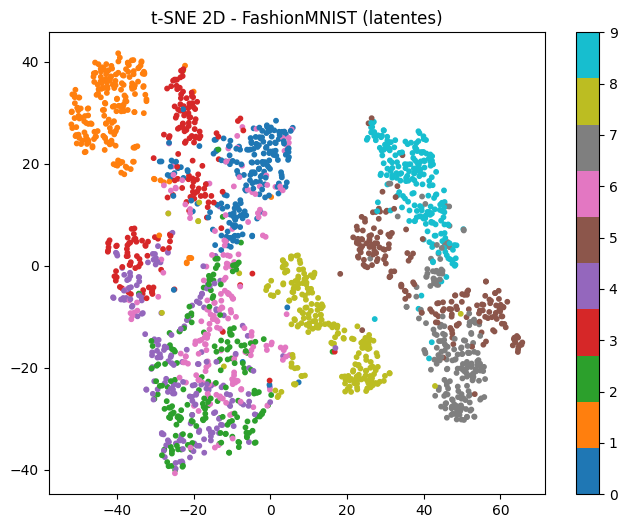

In [17]:
def plot_2D(latentes, labels, title=""):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(latentes[:,0], latentes[:,1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.show()

# Reducción a 2D con t-SNE
tsne_2d = TSNE(n_components=2, random_state=42)
subset_size = 2000  # para no demorar demasiado
idx = np.random.choice(len(train_latentes), subset_size, replace=False)
latentes_sub = train_latentes[idx]
labels_sub = train_labels[idx]

latentes_2d = tsne_2d.fit_transform(latentes_sub)
plot_2D(latentes_2d, labels_sub, title="t-SNE 2D - FashionMNIST (latentes)")

In [23]:
# Reducción a 3D con t-SNE
tsne_3d = TSNE(n_components=3, random_state=42)
latentes_3d = tsne_3d.fit_transform(latentes_sub)

import plotly.express as px
fig = px.scatter_3d(
    latentes_3d, x=0, y=1, z=2, color=labels_sub,
    color_continuous_scale=px.colors.qualitative.T10,
    labels={'color': 'Etiqueta real'}
)
fig.update_layout(title="t-SNE 3D - FashionMNIST (latentes)")
fig.show()

## Detección de anomalías

Para ver la capacidad de los autoencoders para la detección de anomalías, mezclaremos datos de FashionMNIST y de MNIST en un mismo dataset. Tomaremos 2000 imágenes de cada uno y entrenaremos (o simplemente evaluaremos la reconstrucción) para ver si la reconstrucción es peor con MNIST (donde el autoencoder no fue entrenado).

Generaremos un histograma o scatter plot del error de reconstrucción, coloreando por "Fashion" vs "Digit".

- Cargamos MNIST
- Seleccionamos 2000 ejemplos aleatorios de MNIST y 2000 de FashionMNIST
- Calculamos la reconstrucción y el error
- Graficamos distribución del error

In [21]:
# Cargar MNIST
mnist_train = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
mnist_test = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# Concatenamos train+test de MNIST para tener más muestras
mnist_full = torch.utils.data.ConcatDataset([mnist_train, mnist_test])
# Idem para fashion (aunque ya lo tenemos)
fashion_full = torch.utils.data.ConcatDataset([fashion_train, fashion_test])

def sample_dataset(dataset, n=2000):
    # Toma n muestras aleatorias del dataset
    indices = random.sample(range(len(dataset)), n)
    return torch.utils.data.Subset(dataset, indices)

mnist_sample = sample_dataset(mnist_full, 2000)
fashion_sample = sample_dataset(fashion_full, 2000)

# Creamos un DataLoader combinado
# Asignamos etiqueta 0 para MNIST y 1 para FashionMNIST, p.ej.
anomaly_data = []
anomaly_labels = []

for img, label in mnist_sample:
    anomaly_data.append(img)
    anomaly_labels.append(0)  # 0 = MNIST

for img, label in fashion_sample:
    anomaly_data.append(img)
    anomaly_labels.append(1)  # 1 = Fashion

# Convertimos a tensores
anomaly_data = torch.stack(anomaly_data)
anomaly_labels = torch.tensor(anomaly_labels)
print("Tamaño del dataset combinado:", anomaly_data.shape, anomaly_labels.shape)

class AnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

anomaly_dataset = AnomalyDataset(anomaly_data, anomaly_labels)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=128, shuffle=False)


Tamaño del dataset combinado: torch.Size([4000, 1, 28, 28]) torch.Size([4000])


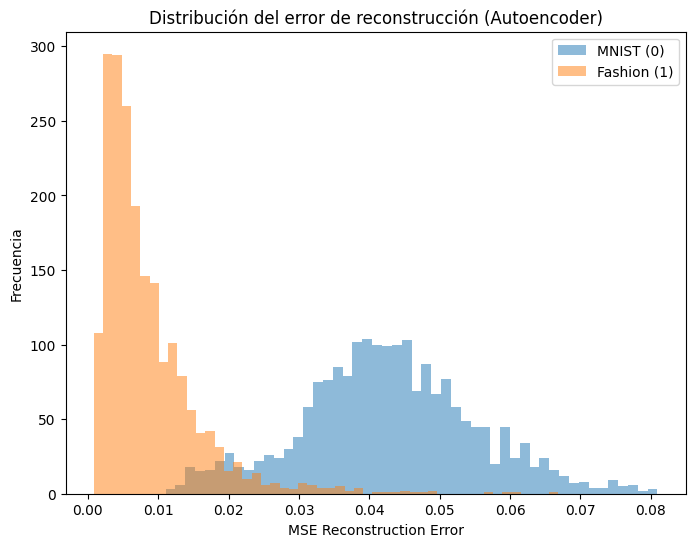

In [22]:
# Ahora calculamos error de reconstrucción para cada imagen
model.eval()
errors = []
labels_anom = []

with torch.no_grad():
    for images, labs in anomaly_loader:
        images = images.to(device)
        output = model(images)
        loss = torch.mean((output - images)**2, dim=[1,2,3])  # MSE por ejemplo
        
        errors.extend(loss.cpu().numpy())
        labels_anom.extend(labs.cpu().numpy())

errors = np.array(errors)
labels_anom = np.array(labels_anom)

# Graficar histograma de errores, coloreando por MNIST(0) vs Fashion(1)
plt.figure(figsize=(8,6))
plt.hist(errors[labels_anom==0], bins=50, alpha=0.5, label="MNIST (0)")
plt.hist(errors[labels_anom==1], bins=50, alpha=0.5, label="Fashion (1)")
plt.legend()
plt.title("Distribución del error de reconstrucción (Autoencoder)")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Frecuencia")
plt.show()